In [8]:
from loadTDMS import *
from fft_test import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

## CF面積、高速計算ver

In [9]:
#　移動平均のための np_array作成
# x = np.linspace(-1,1,1000)
x = np.linspace(-1,1,100)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

# plt.plot(v,linewidth=3)
# plt.plot(v2,linewidth=3)

 12%|█▏        | 20/169 [00:14<01:55,  1.29it/s]<ipython-input-10-08f66667d2bf>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure, ax = plt.subplots()
100%|██████████| 169/169 [02:13<00:00,  1.26it/s]


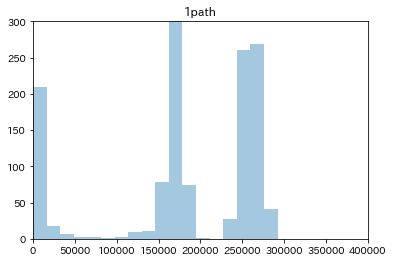

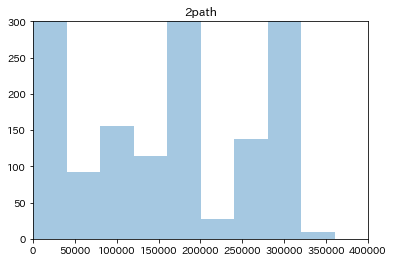

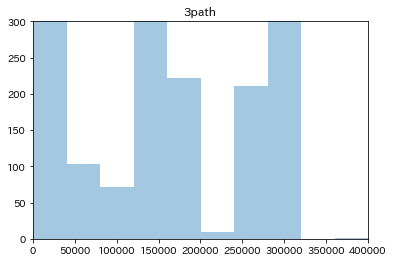

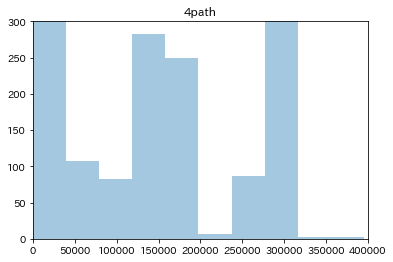

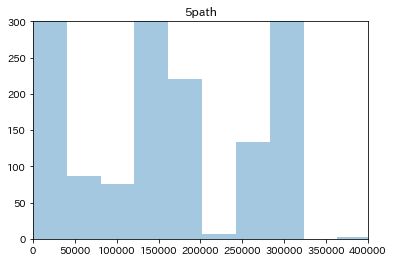

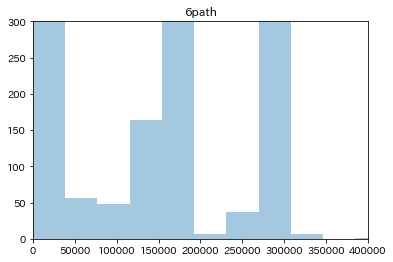

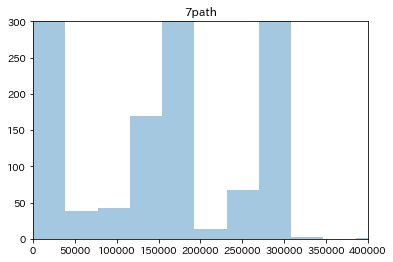

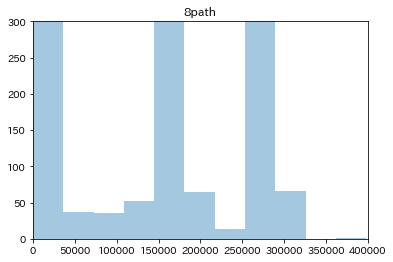

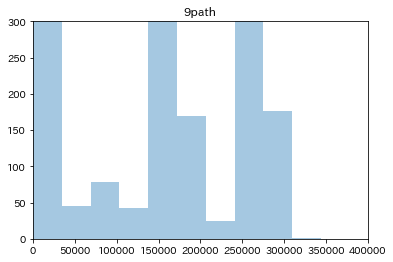

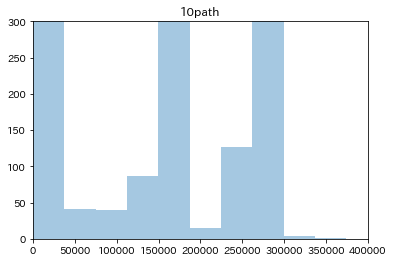

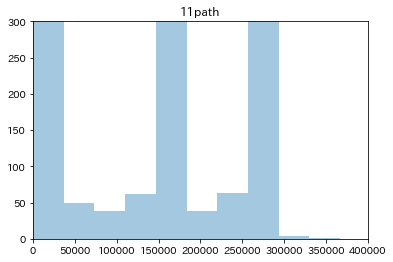

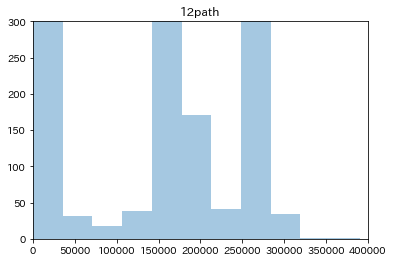

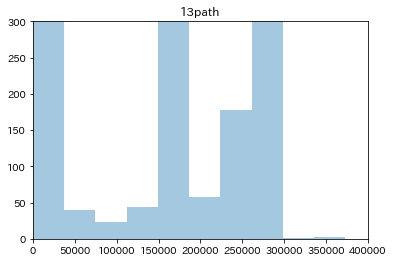

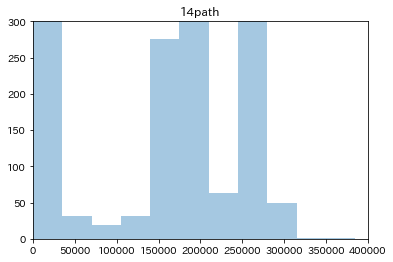

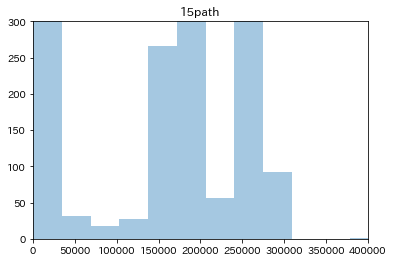

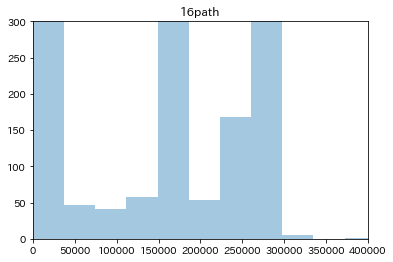

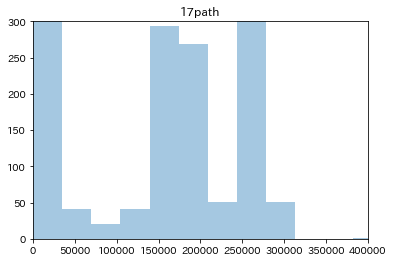

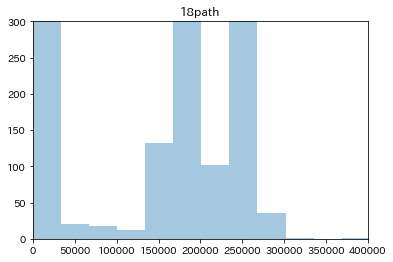

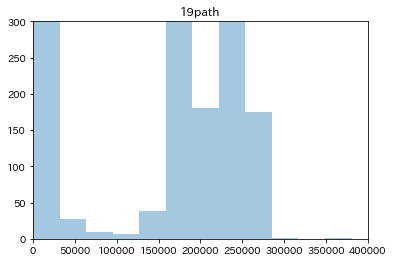

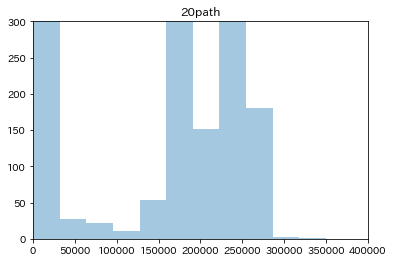

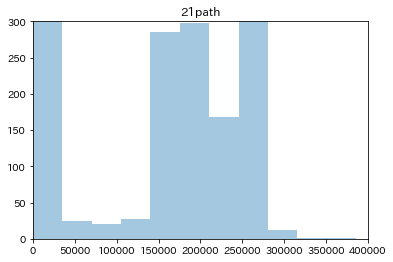

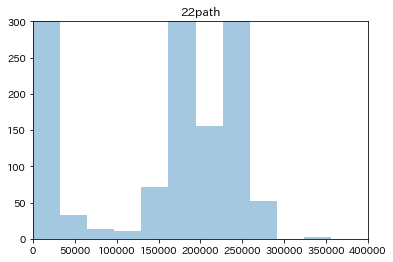

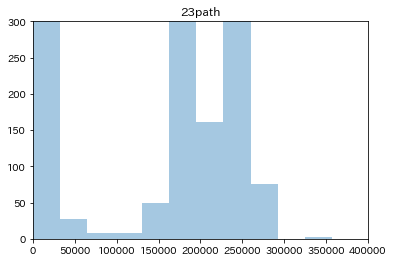

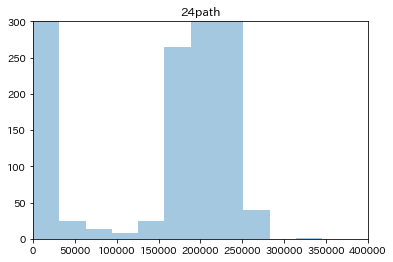

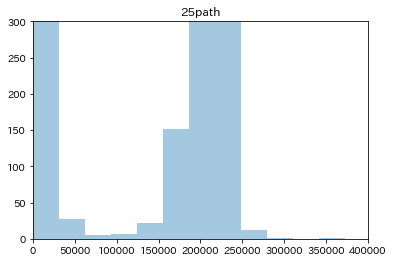

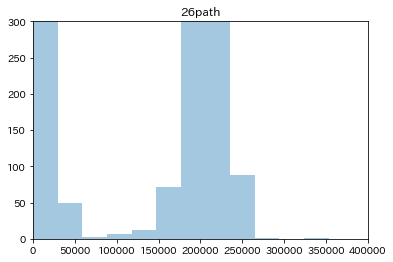

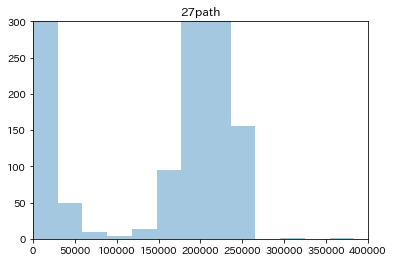

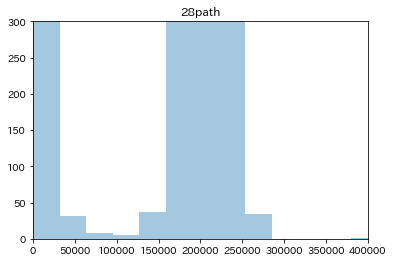

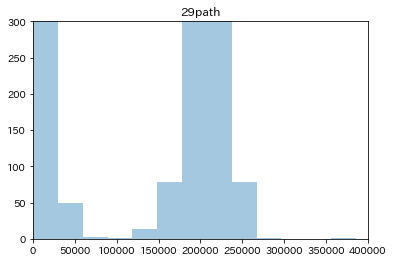

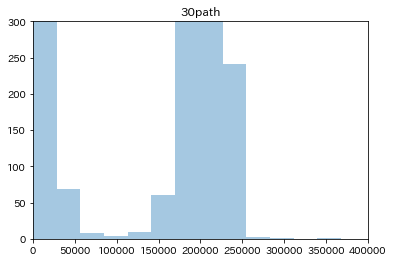

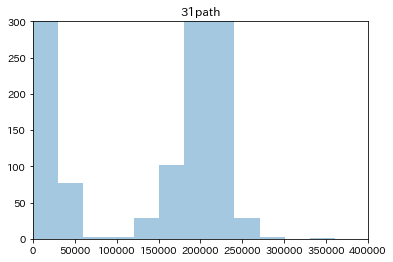

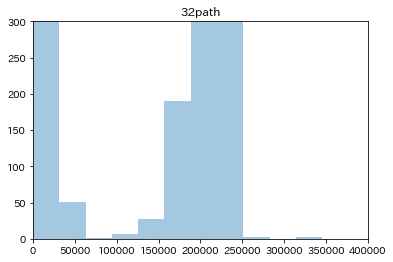

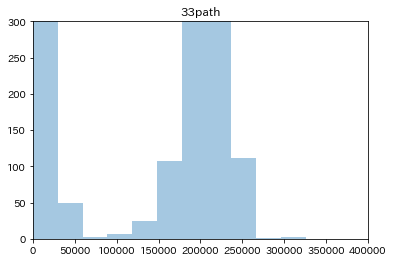

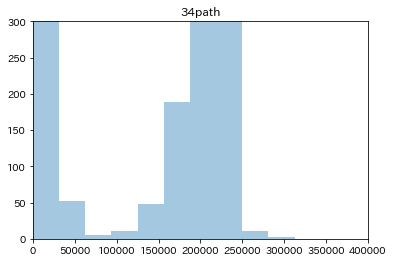

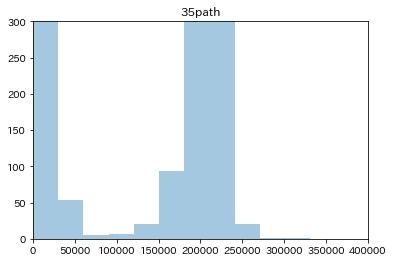

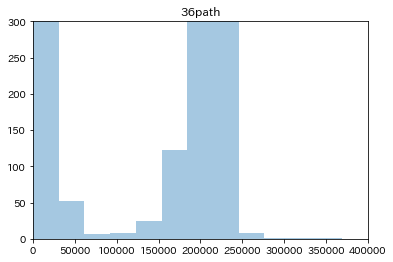

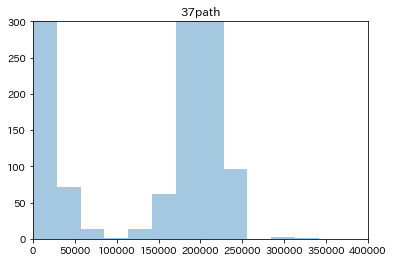

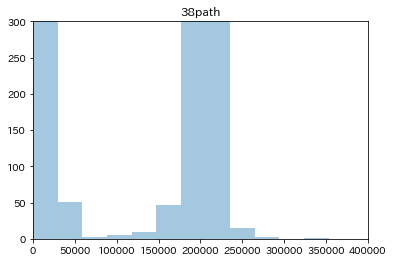

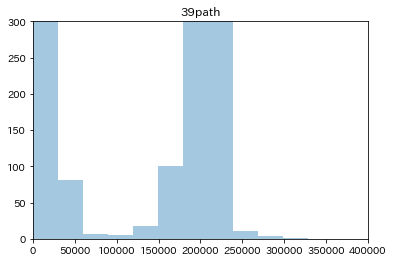

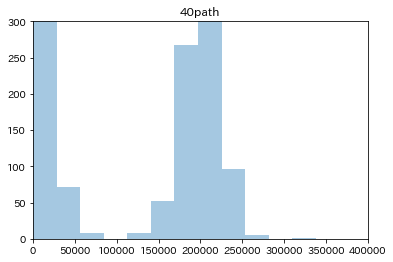

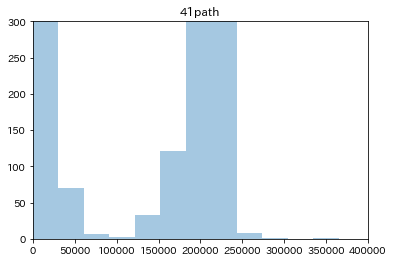

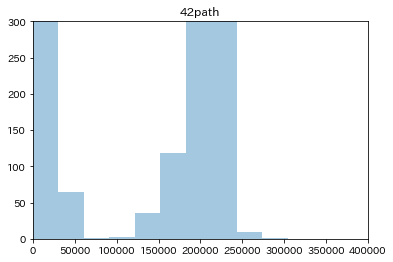

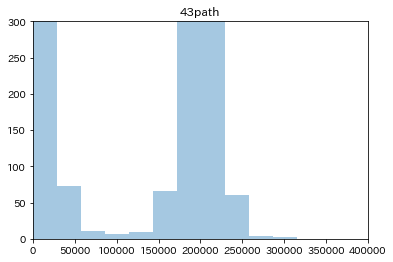

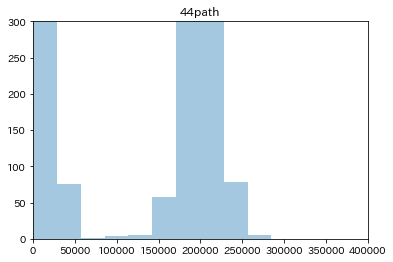

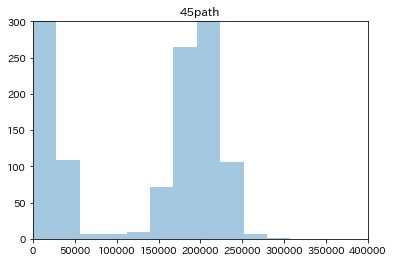

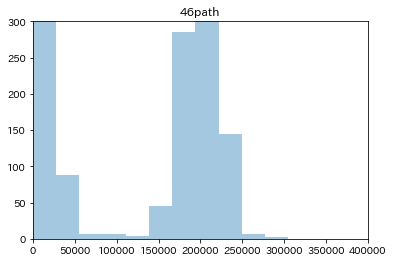

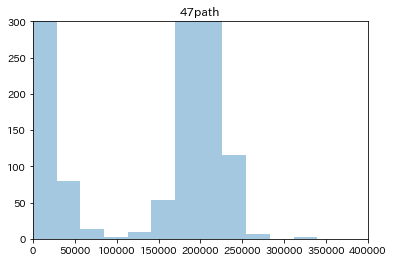

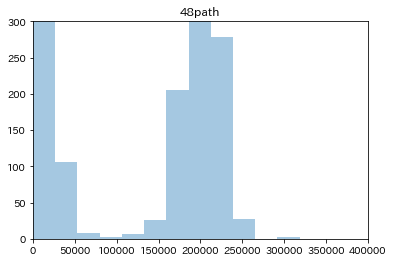

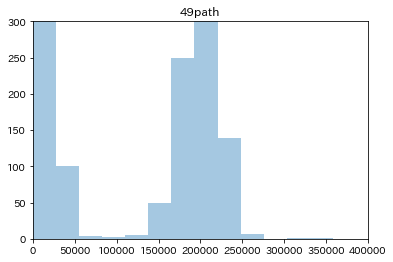

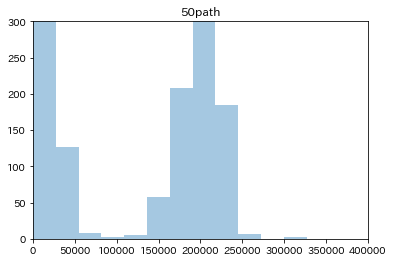

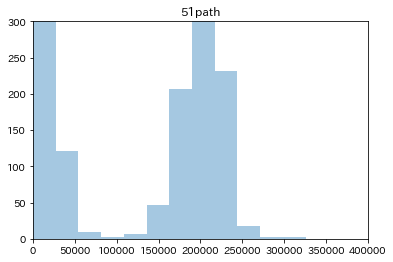

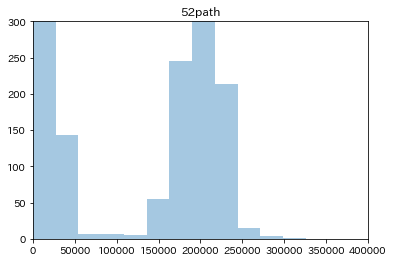

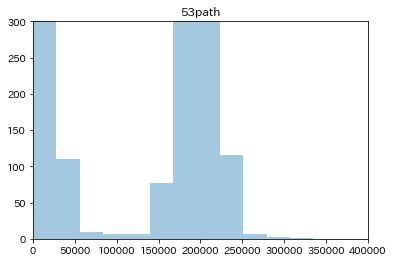

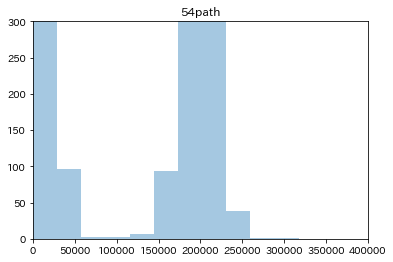

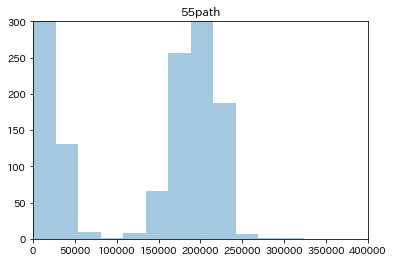

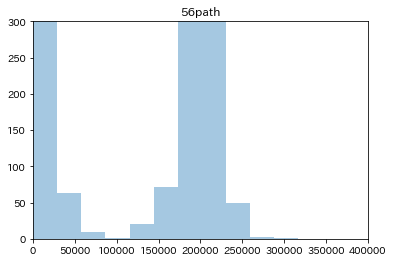

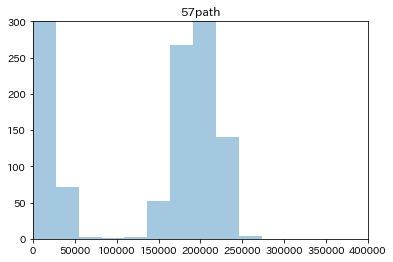

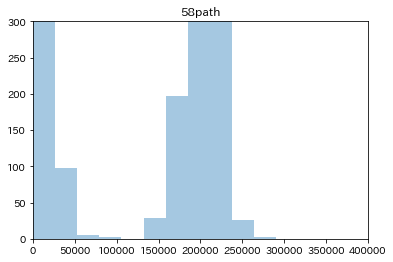

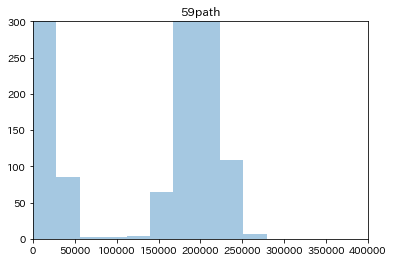

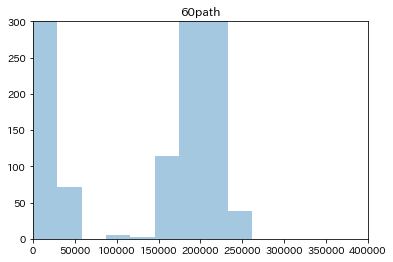

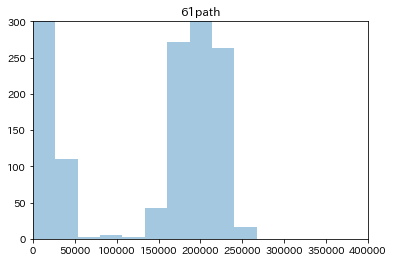

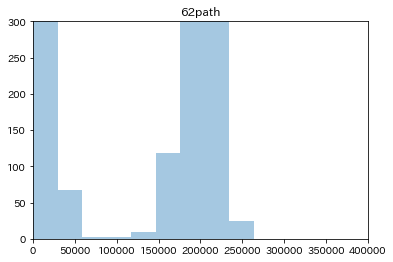

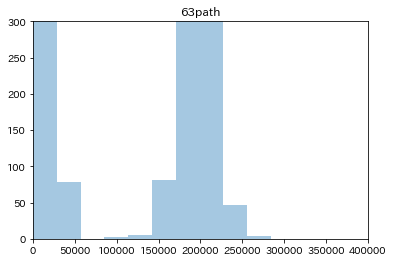

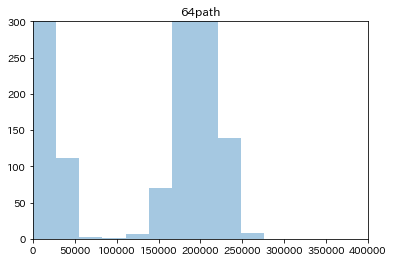

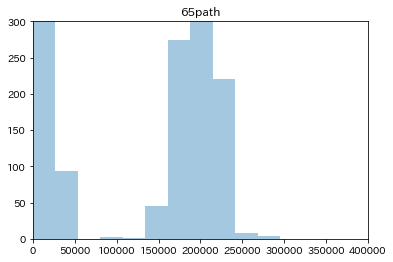

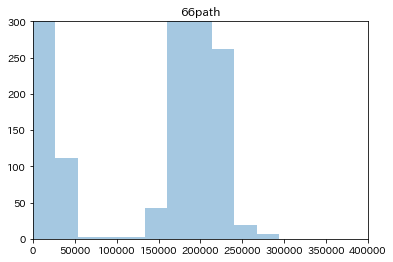

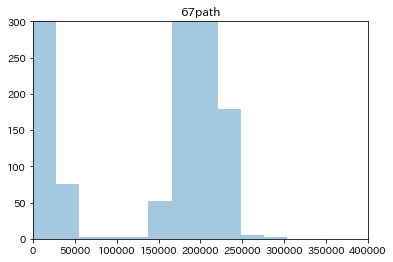

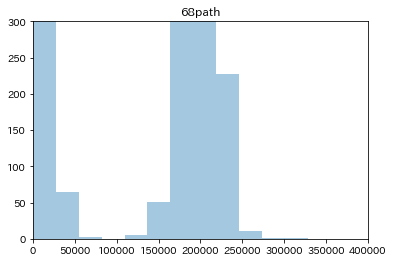

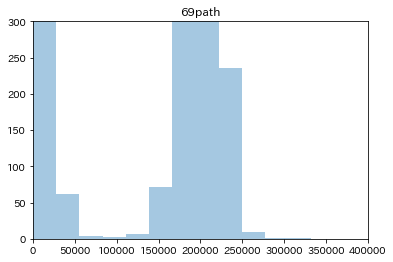

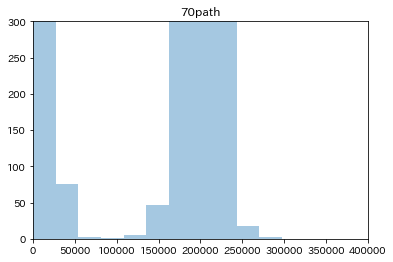

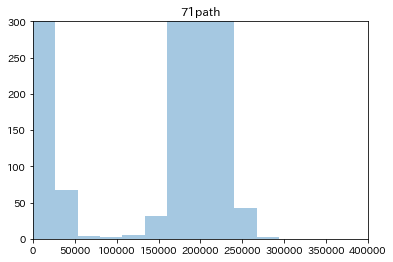

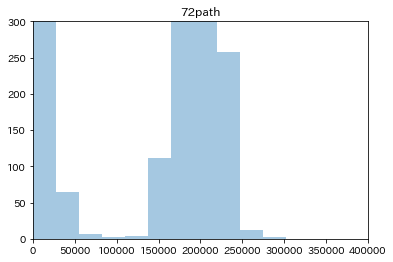

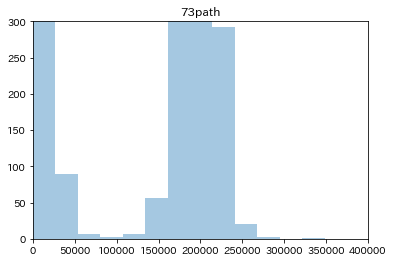

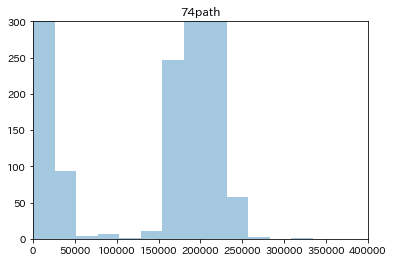

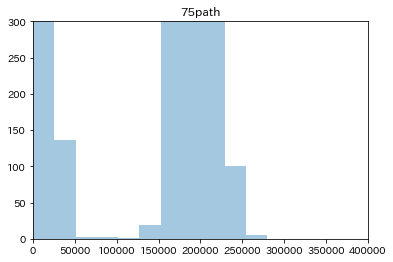

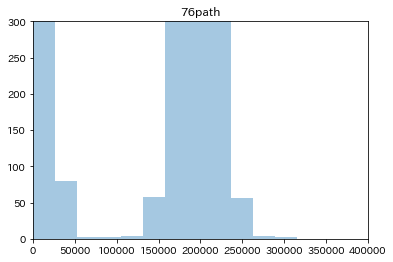

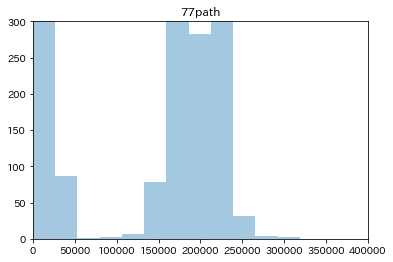

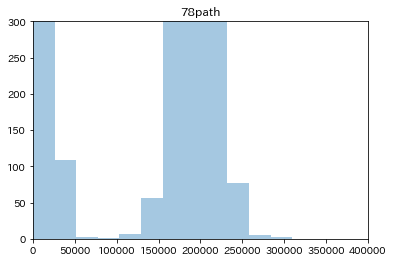

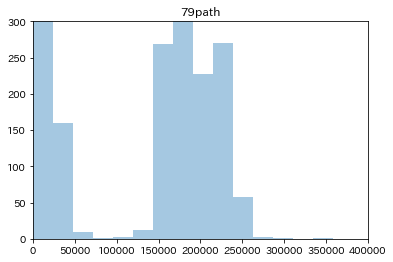

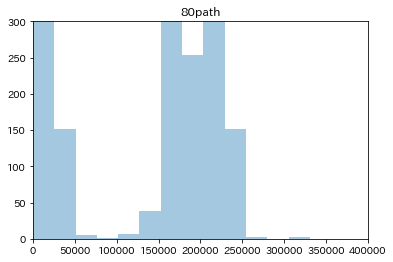

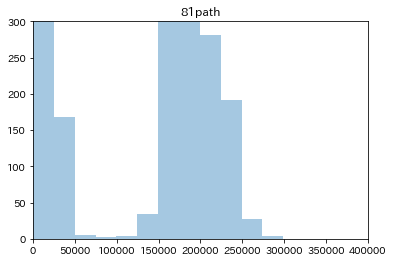

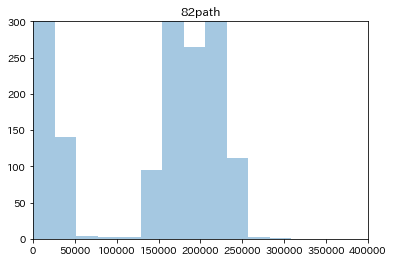

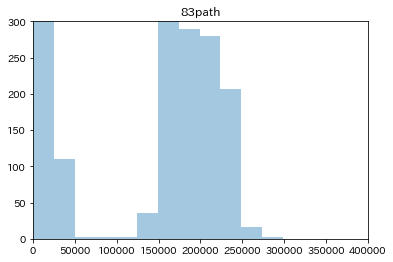

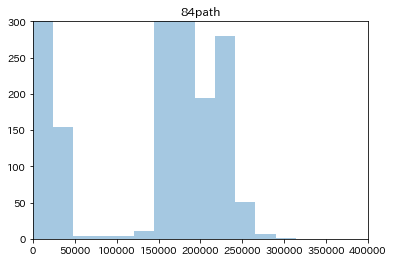

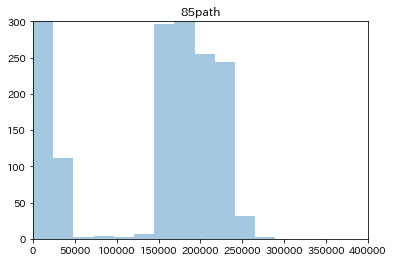

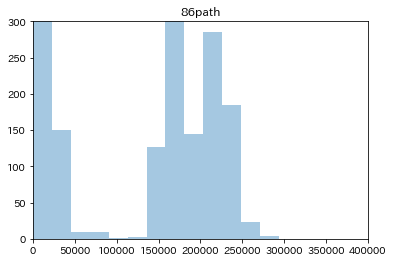

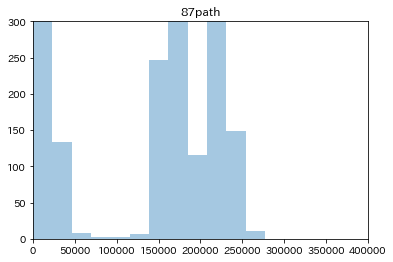

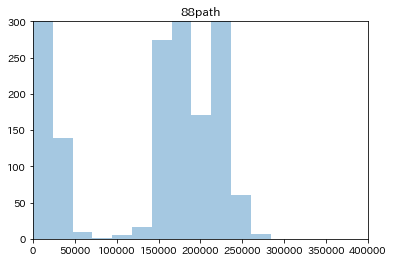

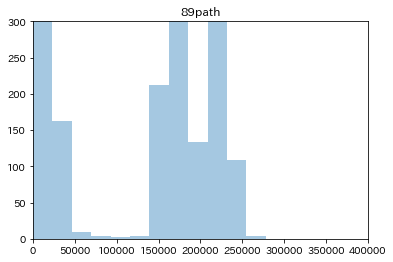

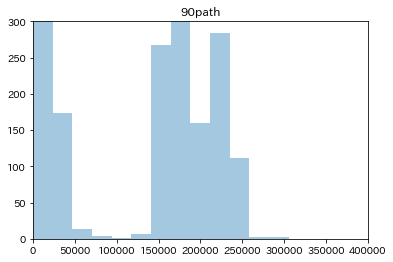

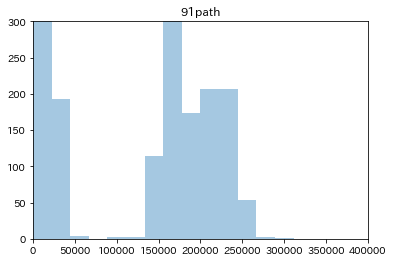

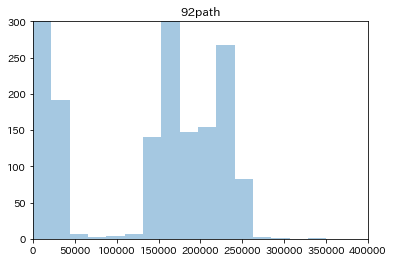

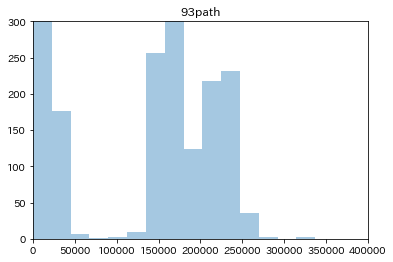

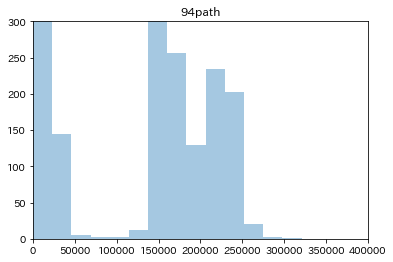

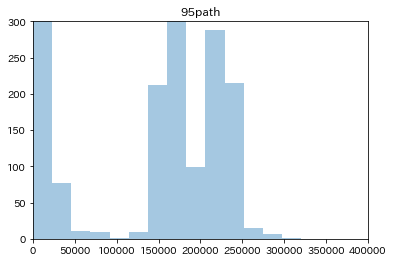

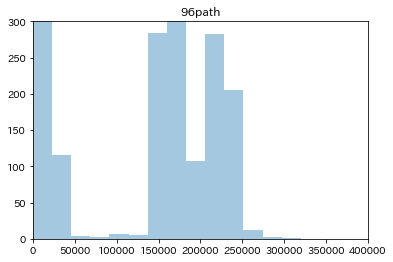

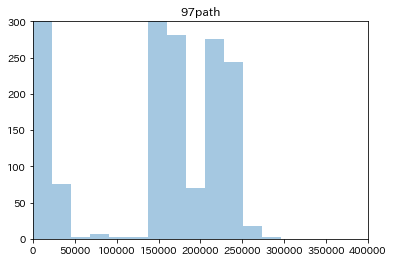

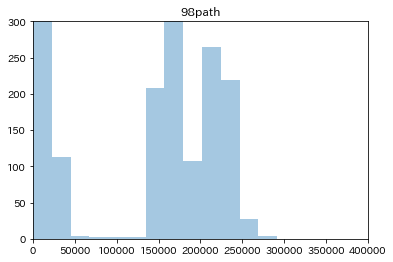

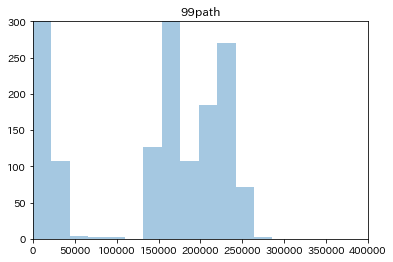

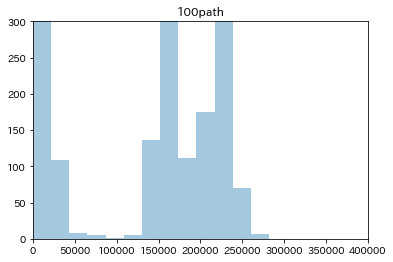

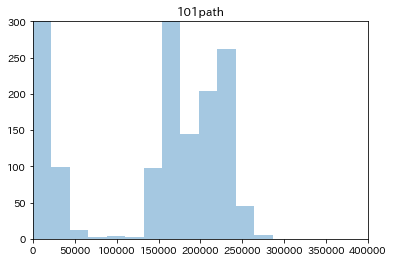

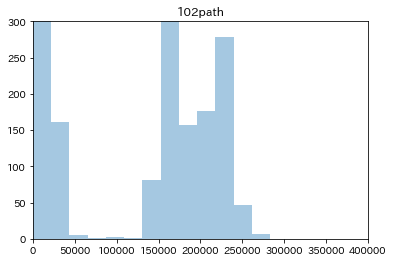

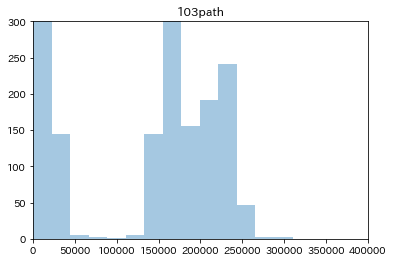

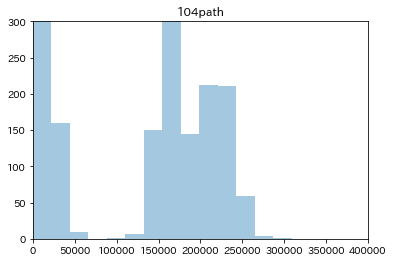

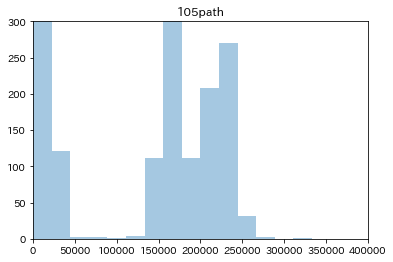

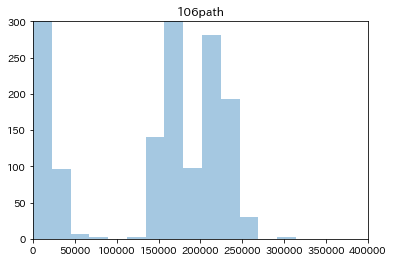

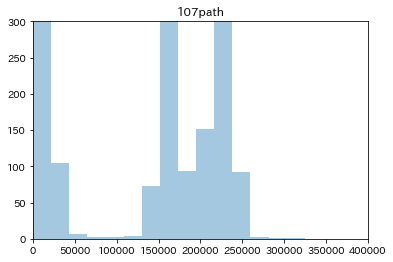

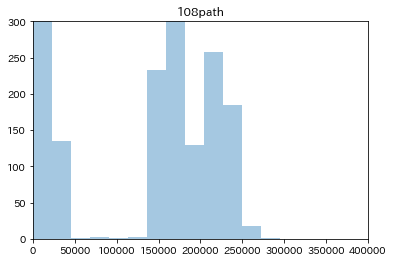

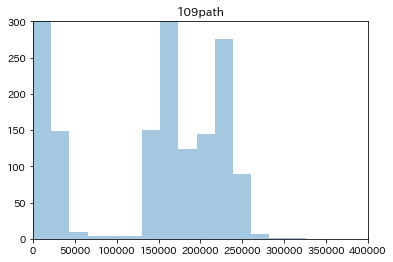

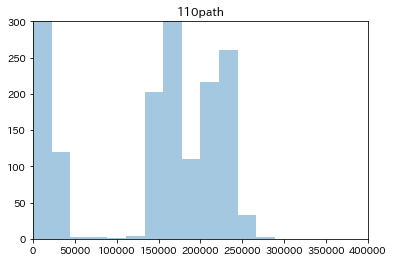

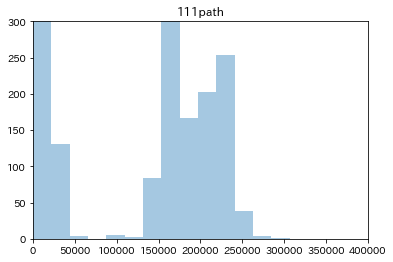

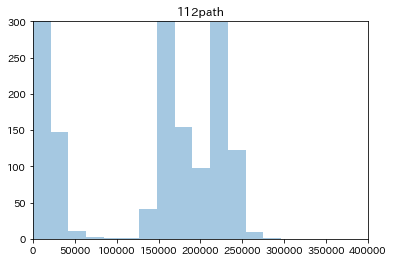

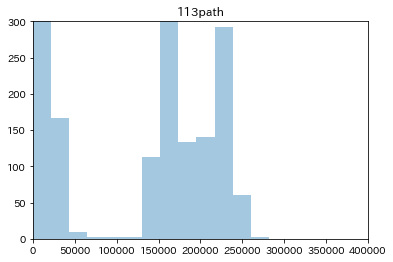

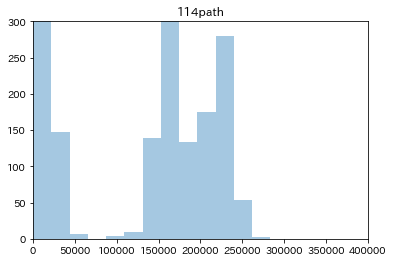

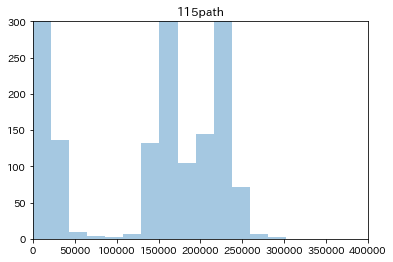

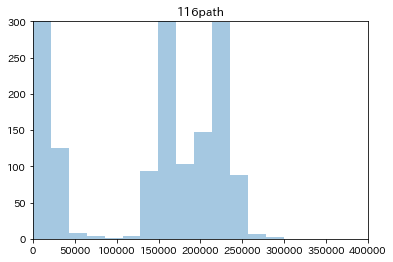

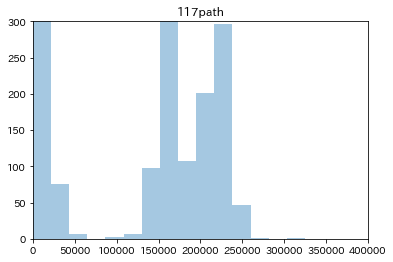

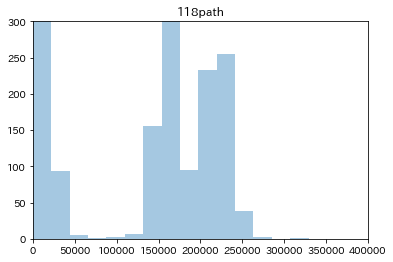

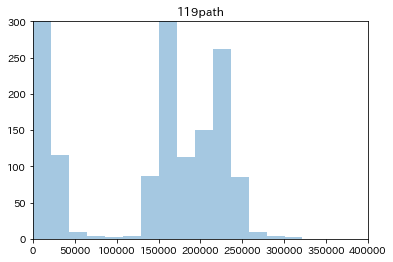

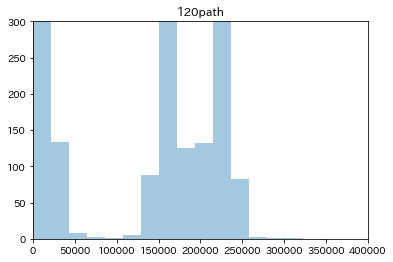

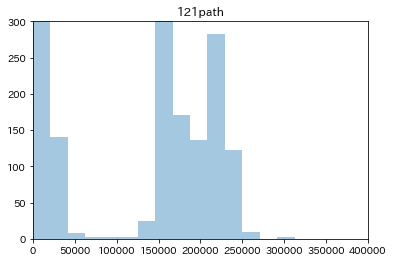

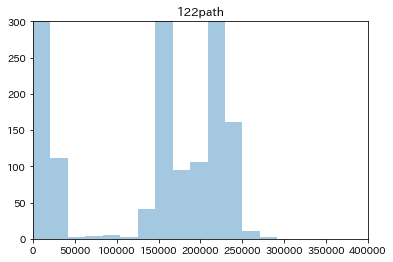

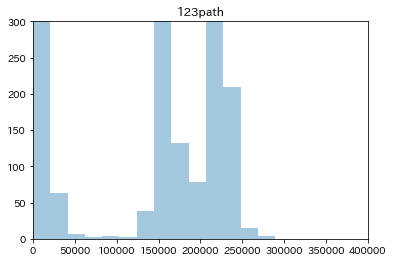

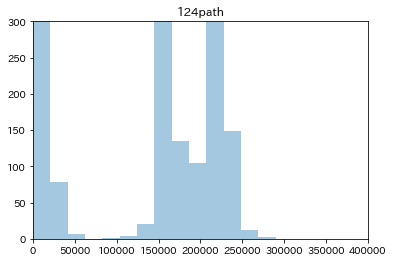

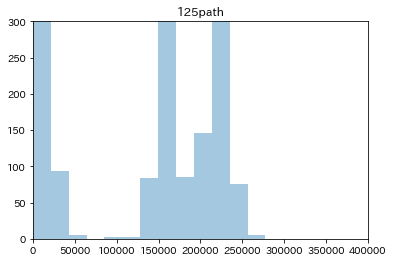

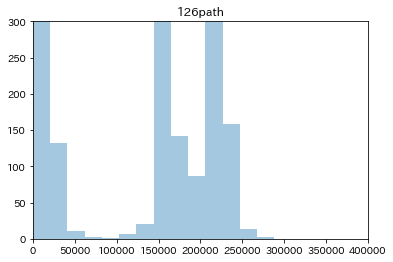

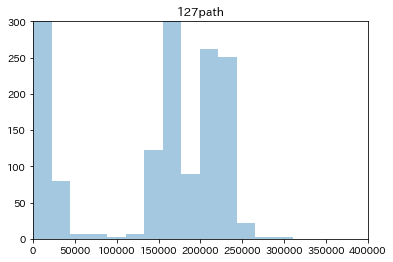

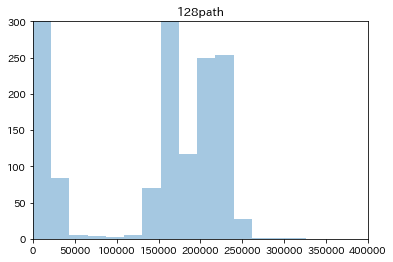

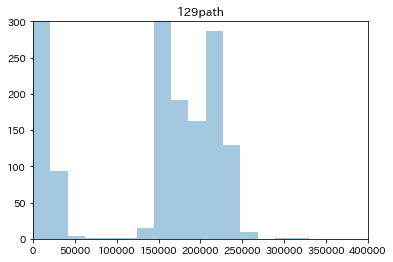

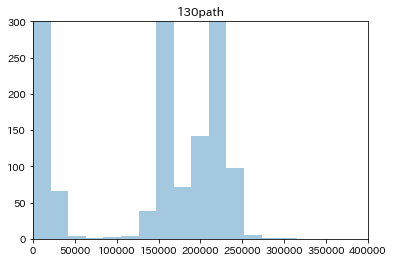

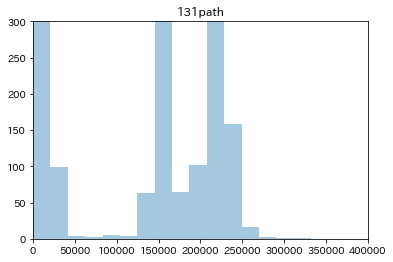

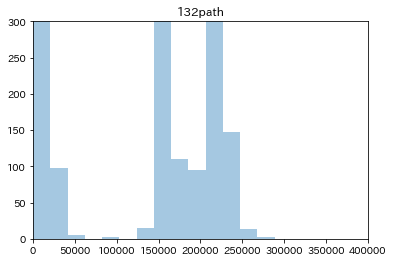

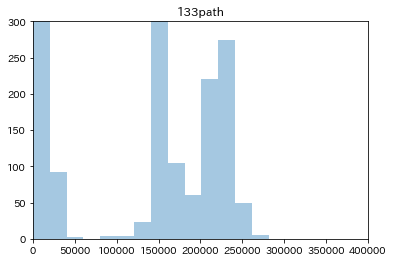

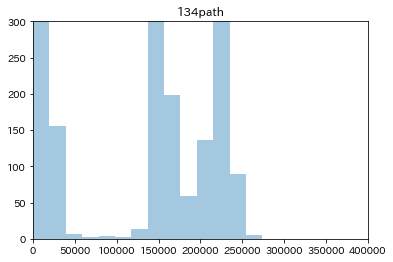

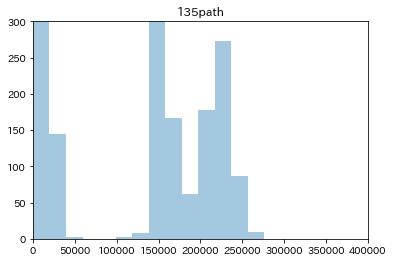

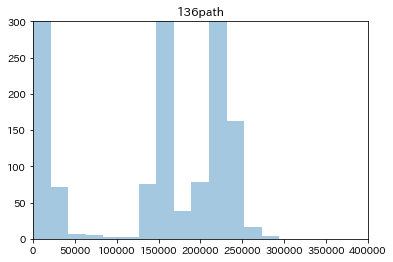

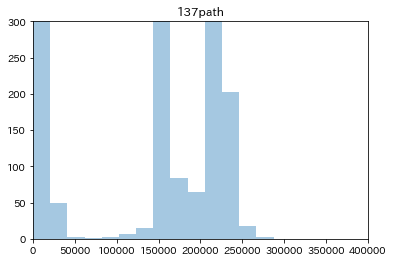

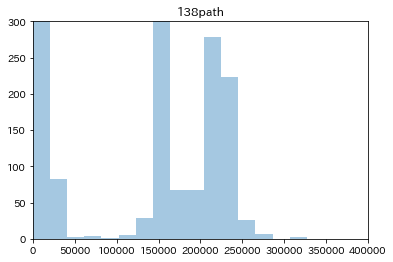

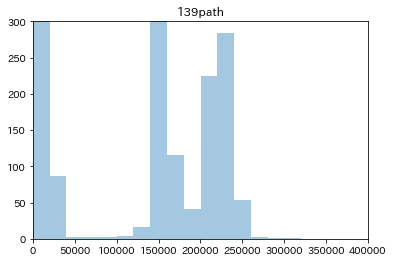

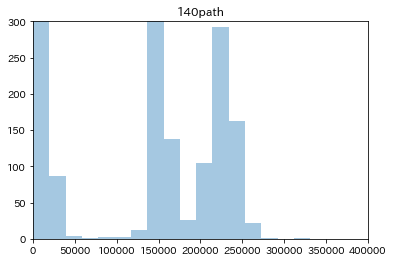

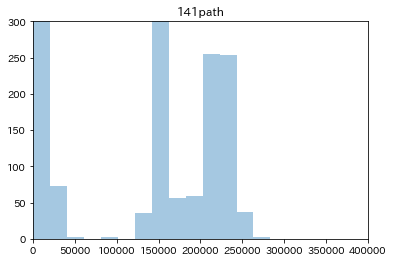

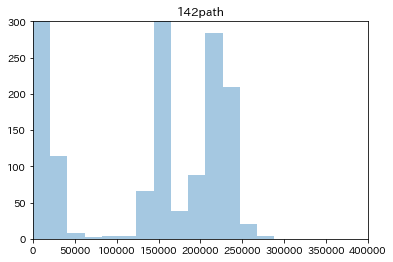

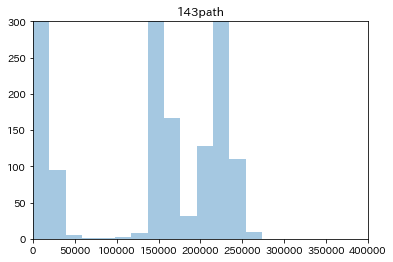

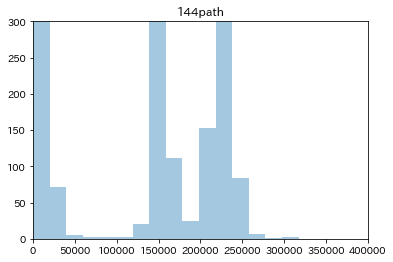

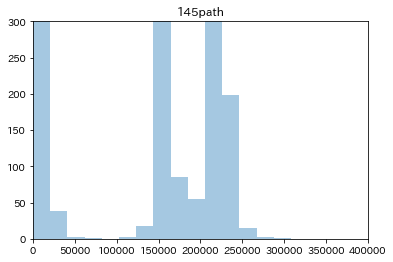

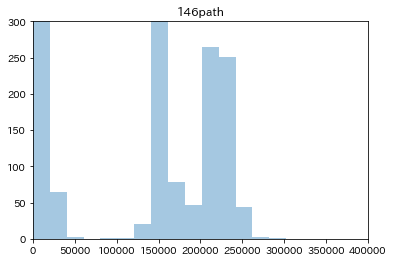

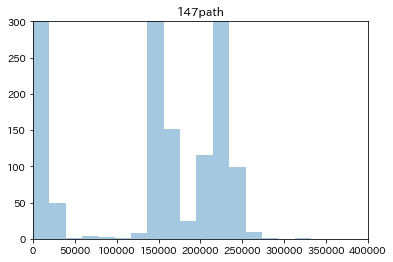

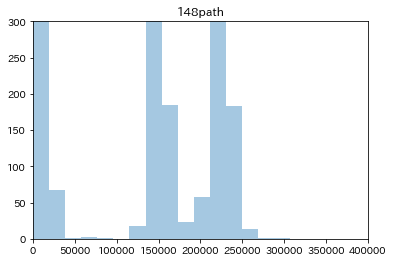

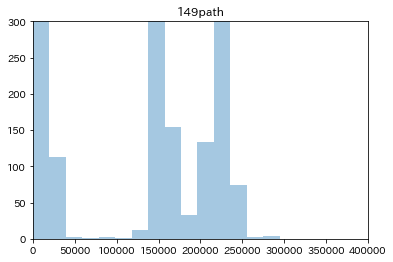

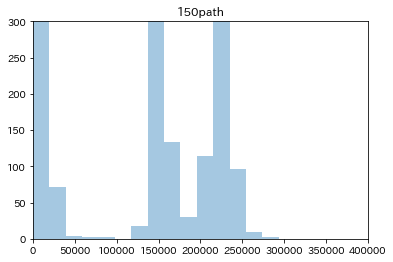

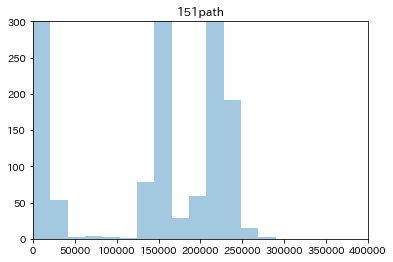

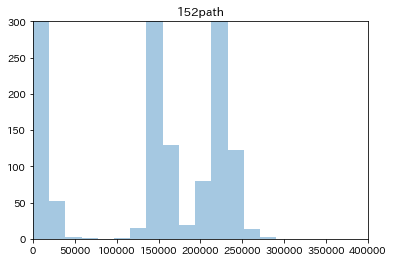

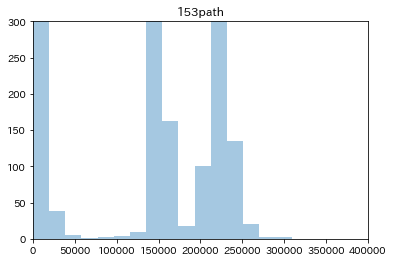

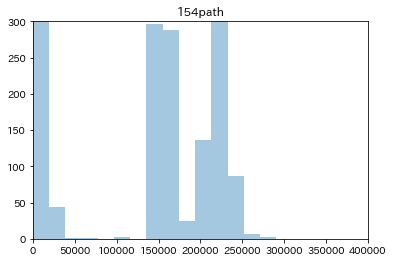

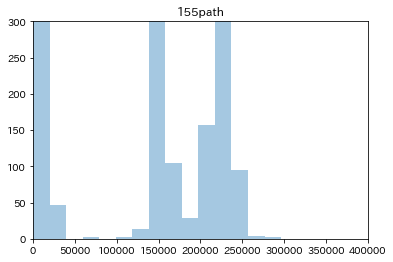

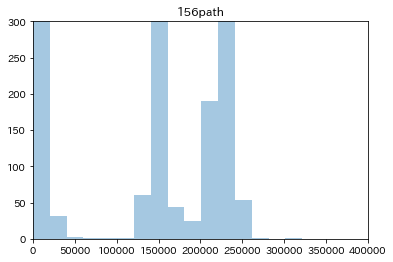

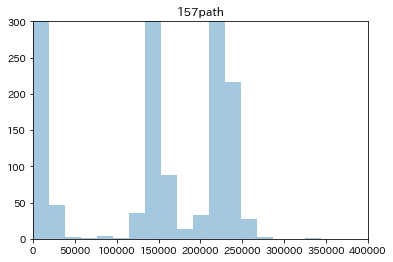

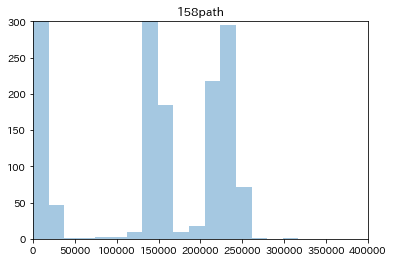

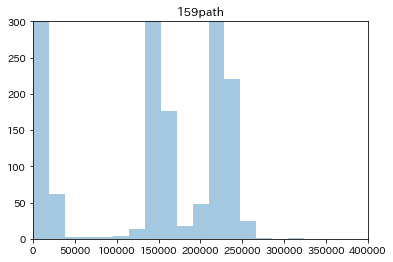

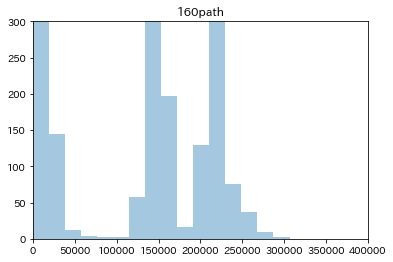

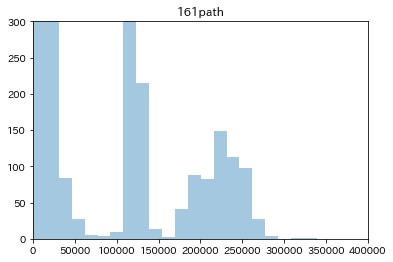

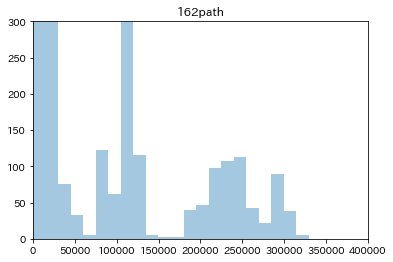

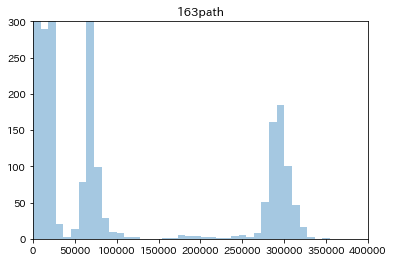

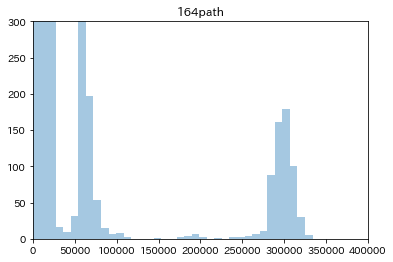

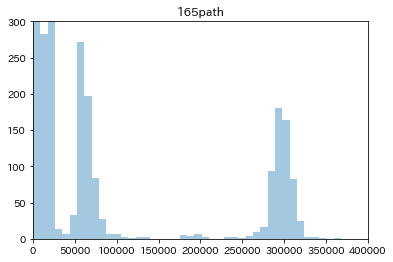

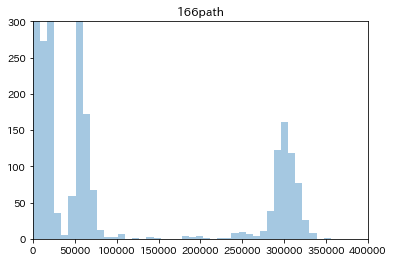

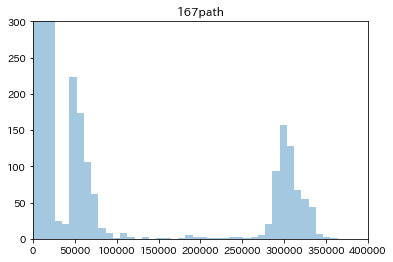

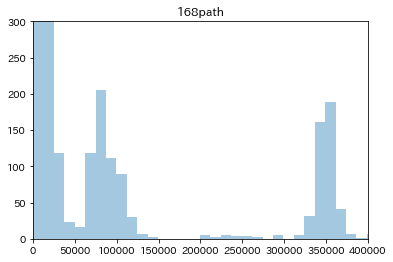

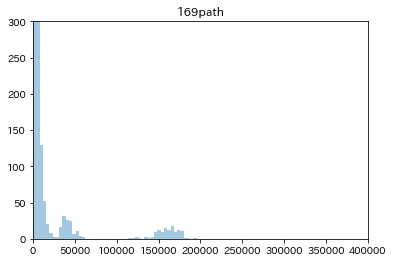

In [10]:
for num in tqdm(range(1,170)):
    figure, ax = plt.subplots()
    
    #　データ読み込み
    cf = np.load(rf"Z:\200 Produced_data\20221027\CF\{num}.npy")
    
    #　負の値を0に
    cf[cf < 0] = 0
    
    #　移動平均でノイズ除去
    cf_m_avg = np.convolve(cf,v, mode='valid')
    cf_m_avg[cf_m_avg < 5] = 0
    
    #　0であるところのstartとendを特定する.高速ver
    cf_w = np.where(cf_m_avg != 0)[0]
    cf_wd = cf_w[1:] - cf_w[:-1]
    cf_wdd = np.where(cf_wd != 1)[0]
    cf_wdd = cf_wdd + 1
    
    #　面積計算
    menseki = []
    #　最初の回転の面積
    menseki.append(np.sum(np.array(cf_m_avg[0:cf_w[cf_wdd[0]]])))
    
    #　最初と最後以外の面積
    for i in range(len(cf_wdd)-1):
        menseki.append(np.sum(np.array(cf_m_avg[cf_w[cf_wdd[i]]:cf_w[cf_wdd[i+1]]])))
        
    #　最後の回転の面積
    menseki.append(np.sum(np.array(cf_m_avg[cf_w[cf_wdd[-1]] : len(cf_m_avg)])))

    #　1path分の面積データ.npy保存
    np.save(rf"Z:\200 Produced_data\20221027\CF\menseki\npy\{num}", np.array(menseki))
    
    #　1path分の面積ヒストグラム生成
    ax.set_ylim(0, 300)
    ax.set_xlim(0, 400000)
    hist_p = sns.distplot(menseki, kde=False, rug=False)
    figure = hist_p.get_figure()
    hist_p.set_title(rf"{num}path")
    figure.savefig(rf"Z:\200 Produced_data\20221027\CF\menseki\fig\100\{num}.png")


## 各pathのCF面積の標準偏差

In [53]:
cf_std = []
for num in tqdm(range(1,170)):
    cf = np.load(rf"Z:\200 Produced_data\20221027\CF\menseki\npy\{num}.npy")
    cf_std.append(np.std(cf))
cf_std = np.array(cf_std)
np.save(rf"Z:\200 Produced_data\20221027\CF\menseki\npy\std", cf_std)

100%|██████████| 169/169 [00:01<00:00, 97.09it/s] 


In [24]:
%matplotlib qt
fig = plt.figure()
plt.plot(cf_std)

## CFの面積推移（半回転ごとの面積）

In [28]:
cf1 = np.load(rf"Z:\200 Produced_data\20221027\CF\menseki\npy\1.npy")
for num in tqdm(range(2,170)):
    cf2 = np.load(rf"Z:\200 Produced_data\20221027\CF\menseki\npy\{num}.npy")
    cf1 = np.concatenate([cf1, cf2], axis=0)

np.save(rf"Z:\200 Produced_data\20221027\CF\menseki\npy\All", cf1)

100%|██████████| 168/168 [00:01<00:00, 87.04it/s]


In [49]:
%matplotlib qt
fig = plt.figure()

plt.plot(cf1)

## CF面積推移とFFT面積推移重ねて表示（未完成）

In [56]:
ae_0_50 = np.load(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\100kHz\AllNorm_0-50khz_test.npy")
ae_400_450 = np.load(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\100kHz\AllNorm_400-450khz_test.npy")
cf_std = np.load(rf"Z:\200 Produced_data\20221027\CF\menseki\npy\std.npy")

ae_0_50 = ae_0_50.ravel()[:99408]
ae_400_450 = ae_400_450.ravel()[:99408]

In [75]:
%matplotlib qt
# fig = plt.figure()
fig = plt.figure(figsize=(11.69*0.9,8.27*0.9), dpi=100)
ax = fig.add_subplot()

ax.set_xticks(np.arange(1, 169, 20))
ax.set_xticklabels(np.arange(0,170,20))

ax.set_xlabel(xlabel='Path Number', size=18, labelpad=18)
ax.set_ylabel(ylabel='CF std', size=18, labelpad=18)


ax.tick_params(axis = 'x', labelsize = 18)
ax.tick_params(axis = 'y', labelsize = 18)

# ax2 = ax.twinx()

ax2.set_xticks(np.arange(1, 169*591, 591*20))
ax2.set_xticklabels(np.arange(0,170,20))

ax2.set_xlabel(xlabel='Path Number', size=18, labelpad=18)
ax2.set_ylabel(ylabel='S (AE spectrum area)', size=18, labelpad=13)

ax2.tick_params(axis = 'x', labelsize = 18)
ax2.tick_params(axis = 'y', labelsize = 18)


ae_0_50_moving_avg = np.convolve(ae_0_50,v, mode='valid')
ae_400_450_moving_avg = np.convolve(ae_400_450,v, mode='valid')

ax.plot(cf_std, lineWidth="5", color="red", label="CF std")
ax2.plot(ae_0_50_moving_avg, lineWidth="3", lineStyle="dashdot", color="magenta", label="S (0-50kHz)")

# ax2.plot(ae_400_450_moving_avg,lineWidth="3", lineStyle="dashdot", color="magenta",label="400-450kHz")



In [170]:
print(menseki.max())
print(menseki.min())

338862.96157391183
165.2238794484116


In [14]:
# x_min = int(menseki.max())
# x_max = int(menseki.min())
# range_bin_width = range(x_min, x_max, 60)

# fig = plt.figure()

# x_min = 0
# x_max = 350000

# range_bin_width = range(x_min, x_max, 7)


figure, ax = plt.subplots()
# dd = np.load(rf"Z:\200 Produced_data\20221027\FFTonePath_Focus\menseki\Aligned\{num}.npy")
# hist_p = sns.distplot(menseki, bins=range_bin_width, kde=False, rug=False)
hist_p = sns.distplot(menseki, kde=False, rug=False)
figure = hist_p.get_figure()
hist_p.set_title(rf"{num}path")
ax.set_ylim(0, 300)
figure.savefig(rf"Z:\200 Produced_data\20221027\CF\menseki\fig\{num}.png")


In [9]:
x_min = 0
x_max = 350000

range_bin_width = range(x_min, x_max, 7)
range_bin_width

range(0, 350000, 7)

In [16]:
type(menseki)

numpy.ndarray

In [17]:
menseki.shape

(1218,)

In [33]:
cf = np.load(rf"Z:\200 Produced_data\20221027\CF\160.npy")
cf[cf < 0] = 0


# x = np.linspace(-1,1,1000)
# v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
# v = v / np.sum(v)
# v = np.sort(v)[::-1]

# x2 = np.linspace(-1,1,100)
# v2 = np.exp(-x2**2 / 2) / np.sqrt(2 * np.pi)
# v2 = v2 / np.sum(v2)
# v2 = np.sort(v2)[::-1]


# cf_m_avg = np.convolve(cf,v, mode='valid')
# cf_m_avg[cf_m_avg < 5] = 0
# cf_m_avg2 = np.convolve(cf_m_avg, v2, mode='valid')
print(len(cf_m_avg))
# print(len(cf_m_avg2))
# cf_m_avg = cf_m_avg[1500:8333*50]

4929001


In [5]:
# def diff(x, h):
#     res = x[2:] - x[:-2]
#     return res/(2*h)

In [6]:
# katamuki = diff(cf_m_avg,150)*100000
# katamuki = np.convolve(katamuki,v2,mode='valid')
# henkyoku = diff(katamuki,150)*100000

In [78]:
%matplotlib qt
fig = plt.figure()
k = 8333/2
# k = 4122
plt.axhline(y=0,color='r')
plt.axvline(x = 0, color = 'r')

for i in range(int(len(cf_m_avg)/k)):
    plt.axvline(x = i*k, color = 'r')
    if i%2 == 0:
        plt.axvspan(i*k, (i+1)*k , facecolor='g', alpha=0.5)

# plt.plot(cf[:8333*3], linewidth=3)
plt.plot(cf_m_avg[:8333*10], linewidth=3)
# plt.plot(cf_m_avg, lineWidth=3)


# plt.plot(cf_m_avg2, lineWidth=2)
# plt.plot(katamuki, linewidth=3)
# plt.plot(katamuki, linewidth=1, marker="o")
# plt.plot(henkyoku, linewidth=3)
# plt.plot(cf, lineWidth=3)

In [33]:
w_size = 100
# v = np.ones(w_size) / w_size


#vを正規分布にする
x = np.linspace(-100, 100, w_size)  # 区間[-10,10]を100等分する101点
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
# v = np.sort(v)[::-1] / w_size

# plt.plot(v)

In [34]:
np.sum(v)

0.4871453571175924

In [24]:
a = np.array([1,5,1])
print(np.sum(a))

7


In [95]:
w_size = 100
x = np.linspace(-1,1,100)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

plt.plot(v)

In [47]:
np.sum(v)

1.0000000000000002

In [82]:
8333*618/333333 * (190/60)

48.923091923091924

In [167]:
8333*591

4924803

In [240]:
#条件設定
interval = 8333/2
start = np.arange(0,2001,100)

#load data
x = np.linspace(-1,1,1000)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v = np.sort(v)[::-1]

cf = np.load(rf"Z:\200 Produced_data\20221027\CF\1.npy")
cf_m_avg = np.convolve(cf,v, mode='valid')
plt.axhline(y=0,color='r')
plt.plot(cf_m_avg)



# #split data
# def split_cf(start_i):
#     return np.array_split(cf_m_avg[start_i:], 591)

# t = np.array(list(map(split_cf, start)))


# #compare
# def compare_cf(cf_split)
    

# (list(map(len, l_s)))



In [ ]:
#compare
def compare_cf(cf_split):
    np.array_split(cf)

In [209]:
len(t[0])

591

In [238]:
for i in range(21):
    print(len(t[i][425])) 

8340
8340
8340
8339
8339
8339
8339
8339
8339
8338
8338
8338
8338
8338
8338
8337
8337
8337
8337
8337
8336


In [ ]:
def compare():
    

In [179]:
arr = np.array([1, 2, 3, 4, 5, 6])

newarr = np.array_split(arr, 5)

print(newarr)


[array([1, 2]), array([3]), array([4]), array([5]), array([6])]


In [171]:
np.arange(0,10,2)

array([0, 2, 4, 6, 8])

In [177]:
np.arange(0,2001,100)

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000])

In [41]:
a = np.array([1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5])
diff_aa = a[1:] - a[:-1]
a_where = np.array(np.where(a != 0)[0].tolist())

In [42]:
a_where

array([  0,   1,   2,   3,   4,  10,  11,  12,  13,  14,  20,  21,  22,
        23,  24,  30,  31,  32,  33,  34,  40,  41,  42,  43,  44,  50,
        51,  52,  53,  54,  60,  61,  62,  63,  64,  70,  71,  72,  73,
        74,  80,  81,  82,  83,  84,  90,  91,  92,  93,  94, 100, 101,
       102, 103, 104, 110, 111, 112, 113, 114, 120, 121, 122, 123, 124])

In [43]:
a_where = np.array(a_where)
diff_a = a_where[1:] - a_where[:-1]
diff_a

array([1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1,
       1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1,
       6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1])

In [44]:
aa_where = np.array(np.where(diff_a != 1)[0].tolist())
aa_where = aa_where + 1
aa_where

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

In [49]:
b = np.array([0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5,0,0,0,0,0,1,2,3,4,5])
# diff_bb = b[1:] - b[:-1]
b_where = np.array(np.where(b != 0)[0].tolist())
b_where

array([  3,   4,   5,   6,   7,  13,  14,  15,  16,  17,  23,  24,  25,
        26,  27,  33,  34,  35,  36,  37,  43,  44,  45,  46,  47,  53,
        54,  55,  56,  57,  63,  64,  65,  66,  67,  73,  74,  75,  76,
        77,  83,  84,  85,  86,  87,  93,  94,  95,  96,  97, 103, 104,
       105, 106, 107, 113, 114, 115, 116, 117, 123, 124, 125, 126, 127])

In [50]:
b = b[b_where[0]:]
b

array([1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 1, 2,
       3, 4, 5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 1, 2, 3, 4,
       5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 0,
       0, 0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0,
       0, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0,
       1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5])

In [51]:
b_where = np.array(np.where(b != 0)[0].tolist())
b_where = np.array(b_where)
diff_b = b_where[1:] - b_where[:-1]
diff_b

array([1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1,
       1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1,
       6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1])

In [52]:
bb_where = np.array(np.where(diff_b != 1)[0].tolist())
bb_where = bb_where + 1
bb_where

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60])

## cf0のところ start end 探す（高速）

In [3]:
#7個あればいい
cf = np.array([1,2,3,4,5,0,0,0,0,0,11,12,13,14,15,0,0,0,0,0,21,22,23,24,25,0,0,0,0,0,31,32,33,34,35,0,0,0,0,0,41,42,43,44,45,0,0,0,0,0,51,52,53,54,55,0,0,0,0,0,61,62,63,64,65])
cf_w = np.where(cf != 0)[0]
cf_w

array([ 0,  1,  2,  3,  4, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 30, 31,
       32, 33, 34, 40, 41, 42, 43, 44, 50, 51, 52, 53, 54, 60, 61, 62, 63,
       64], dtype=int64)

In [4]:
cf_wd = cf_w[1:] - cf_w[:-1]
cf_wd

array([1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1,
       1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1], dtype=int64)

In [5]:
cf_wdd = np.where(cf_wd != 1)[0]
cf_wdd = cf_wdd + 1
cf_wdd

array([ 5, 10, 15, 20, 25, 30], dtype=int64)

In [6]:
np.sum(cf[10:15])

65

In [7]:
np.sum(cf[0:cf_wdd[0]])

15

In [80]:
def get_menseki(arg):
    print(arg)
    return cf[arg]
#     return np.sum(np.array(cf[arg[i]:arg[i+1]]))

In [81]:
menseki = np.array(list(map(get_menseki,cf_wdd)))

5
10
15
20
25
30
35
40
45
50
55
60


In [79]:
menseki

array([0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1])

In [146]:
menseki = []
menseki.append(np.sum(np.array(cf[0:cf_w[cf_wdd[0]]])))
for i in range(len(cf_wdd)-1):
#     print(i)
    menseki.append(np.sum(np.array(cf[cf_w[cf_wdd[i]]:cf_w[cf_wdd[i+1]]])))
#     print(np.sum(np.array(cf[cf_w[cf_wdd[i]]:cf_w[cf_wdd[i+1]]])))
menseki.append(np.sum(np.array(cf[cf_w[cf_wdd[-1]] : len(cf)])))

In [147]:
menseki

[15, 65, 115, 165, 215, 265, 315]

In [ ]:
# 15, 